In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c]


In [3]:
solver_args = Dict(:adaptive => true, :abstol => 1e-6, :reltol => 1e-6)

Dict{Symbol, Real} with 3 entries:
  :reltol   => 1.0e-6
  :adaptive => true
  :abstol   => 1.0e-6

In [4]:
spk_args = SpikingArgs(t_window = 0.01, 
                    threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
# solver_args = Dict(:adaptive => false, :dt => 0.01)

In [6]:
# spk_args = SpikingArgs(t_window = 0.01, 
#                     threshold = 0.001,
#                     solver=Heun(), 
#                     solver_args = solver_args)

In [7]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.dt:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [8]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [9]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1))

In [10]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

In [11]:
model, ps, st = build_mlp(args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.09775257 -0.03317157; 0.020251632 0.007017095; … ; 0.04797584 0.04434996; -0.002902955 0.14405486], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_4 = (weight = Float32[-0.7682284 0.26694193 … 0.07480648 0.34993985; 0.15990366 -0.17788795 … -0.27716428 1.1225573], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [12]:
spk_model, _, _ = build_spiking_mlp(args, spk_args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.09775257 -0.03317157; 0.020251632 0.007017095; … ; 0.04797584 0.04434996; -0.002902955 0.14405486], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_4 = (weight = Float32[-0.7682284 0.26694193 … 0.07480648 0.34993985; 0.15990366 -0.17788795 … -0.27716428 1.1225573], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [13]:
y, _ = model(x, ps, st)

([0.02346058082267032 -0.04065883999076729 … -0.04000128330998374 -0.02289207999878682; -0.00787140491302375 -0.001854985554048221 … -0.0022421141877333552 0.001061405585821034], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [18]:
ps.layer_3.bias

128-element Vector{ComplexF32}:
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
       ⋮
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im

In [19]:
y_spk, _ = spk_model(x, ps, st)

(SpikingCall(Spike Train: (2, 256) with 5119 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [20]:
p_spk = train_to_phase(y_spk);

In [21]:
size(p_spk)

(10, 2, 256)

In [22]:
size(y)

(2, 256)

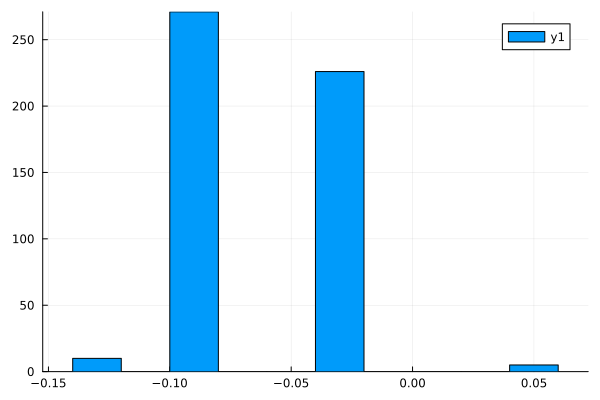

In [23]:
histogram(vec(p_spk[5,:,:]))

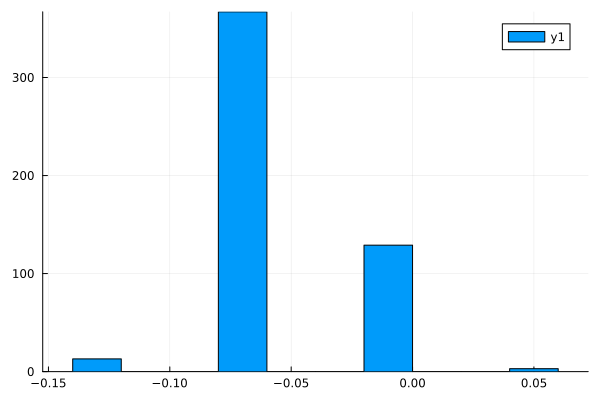

In [24]:
histogram(vec(p_spk[6,:,:]))

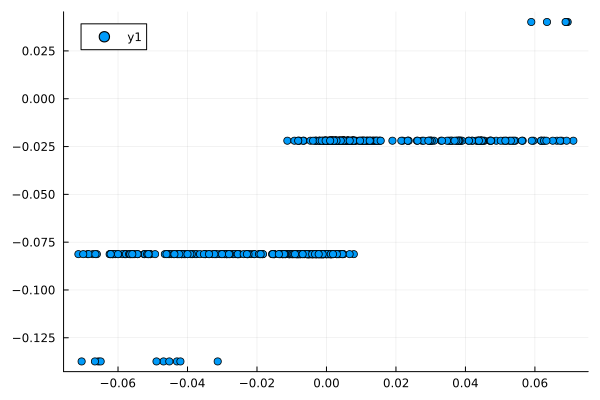

In [25]:
scatter(vec(y), vec(p_spk[5,:,:]))

In [26]:
cycle_correlation(y, p_spk)

10-element Vector{Float64}:
 0.3405969737001484
 0.6391105575752114
 0.66664909597332
 0.8079972528214577
 0.713040983903437
 0.7454854567428562
 0.8755881956995016
 0.867296064952808
 0.8664538273072672
 0.8175108482261988

In [ ]:
scatter()